In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as patches
from scipy.interpolate import interp2d
from scipy.optimize import minimize

from scipy import integrate
import time 

import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from gycad_2d_fem import GymCAD2dFEM
from TwoDtools import *

# from scipy.optimize import basinhopping

In [7]:
# regulam
# 1. stable baseline
# myself

# 

class CutterGame():
    """
    Environment
    """
    def __init__(self, load_data = True):
        self.loading_flag = False
        if load_data != True:
            task_env = GymCAD2dFEM()
            print("Preparing the task")
            task_env.optimization(50, ploting=False)
            self.map_init = np.rot90(task_env.xPhys.copy().reshape((task_env.nelx, task_env.nely)))
        else:
            self.loading_flag = True
            self.loaded_dataset = self.load_dataset()
            self.map_init = self.loaded_dataset[0, :, :]
            
        self.map = self.map_init.copy()
        self.state = np.zeros((40, 40))

        self.current_coords = np.zeros((4, 2))
        self.current_x = np.zeros((1, 8))
        self.max_step = 60
        self.obj = 0
        self.reward = 0

        self.observation_space = [40, 40]
        self.action_space = (16, 0)

        self.reset()
        # without interpolation

    def reset(self):
        if self.loading_flag: # update random saved topology map
            random_idx = np.random.choice(self.loaded_dataset.shape[0], 1)[0]
            self.map_init = self.loaded_dataset[random_idx, :, :]    
            self.map = self.map_init.copy()
            
        _, init_coords = get_init_x(self.map_init)
        self.current_coords[0, 0] = init_coords[0]
        self.current_coords[0, 1] = init_coords[2]
        self.current_coords[1, 0] = init_coords[0]
        self.current_coords[1, 1] = init_coords[3]
        self.current_coords[2, 0] = init_coords[1]
        self.current_coords[2, 1] = init_coords[3]
        self.current_coords[3, 0] = init_coords[1]
        self.current_coords[3, 1] = init_coords[2]
        
        self.counter = 0
        self.update_state()

        return self.state

    def update_state(self):
        self.current_x = pol2x(self.current_coords)
        rows, colomns = fill_2d_with_polygon4(self.current_x)
        self.excluding_indeces = [rows, colomns]
        self.state = np.zeros((40, 40))
        self.integral = np.zeros((40, 40))
        
        # fill the state when figure
        self.state[self.excluding_indeces[0], self.excluding_indeces[1]] = 1  


        # compute objective function
        S = self.state.sum()
        self.integral[self.excluding_indeces[0], self.excluding_indeces[1]] = self.map[self.excluding_indeces[0], self.excluding_indeces[1]]
        Int = self.integral.sum()

        # reward as a difference between new and old objective function values
        self.reward = S - 10*Int - self.obj
        self.obj = S - 10*Int

        # add topology map to the states for the observation
        self.state += self.map*0.5 
        # plt.imshow(self.state)
        # plt.show()

    def sep_step(self, vert_idx, dirs):
        """
        step function for the colution when need to move one vertix of the figure
        vert_idx: int - index of vertex;
        dirs: int - direction of movement: (0: left), (1, right), (2, up), (3, down)
        """
        dir_decode_list = [[1, 0],
                          [-1, 0],
                           [0, 1], 
                           [0, -1]]
        self.current_coords[vert_idx,:] += dir_decode_list[dirs]
        self.update_state()
        self.counter += 1

        # done if number of steps limit
        done = self.counter > self.max_step

        return self.state, self.reward, done, {}, {}

    def step(self, action):
        """
        step function for the colution when need to move one vertix of the figure
        Input: 
            action - int [0, 15]
        """
        vert_idx = action // 4
        dirs = action % 4
        
        dir_decode_list = [[1, 0],
                          [-1, 0],
                           [0, 1], 
                           [0, -1]]
        
        self.current_coords[vert_idx,:] += dir_decode_list[dirs]
        self.update_state()
        self.counter += 1

        # done if number of steps limit
        done = self.counter > self.max_step

        return self.state, self.reward, done, {}

        
    def create_dataset(self, length=100):
        """
        Function creates dataset with topology maps.
        """
        dataset = []
        for iter in range(length):
            print("Iter_n: ", iter)
            task_env = GymCAD2dFEM()
            task_env.optimization(50, ploting=False)
            map = np.rot90(task_env.xPhys.copy().reshape((task_env.nelx, task_env.nely)))
            dataset.append(map)

        dataset = np.array(dataset)
        dataset = dataset.reshape(dataset.shape[0], -1)
        np.savetxt('data4040.csv', dataset, delimiter=',')

    def load_dataset(self):
        """
        The function loads saved dataset.
        """
        loaded_arr = np.loadtxt("data4040.csv", delimiter=',')
 
        loaded_dataset = loaded_arr.reshape(
            loaded_arr.shape[0], loaded_arr.shape[1] // 40, 40)
        return loaded_dataset
    

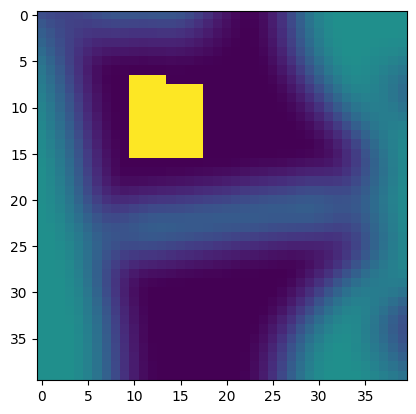

In [8]:
env = CutterGame()
next_state, reward, done, _, _ = env.step(0, 1)

plt.imshow(next_state)
plt.show()

In [9]:
env.create_dataset()

Iter_n:  0
Iter_n:  1
Iter_n:  2
Iter_n:  3
Iter_n:  4
Iter_n:  5
Iter_n:  6
Iter_n:  7
Iter_n:  8
Iter_n:  9
Iter_n:  10
Iter_n:  11
Iter_n:  12
Iter_n:  13
Iter_n:  14
Iter_n:  15
Iter_n:  16
Iter_n:  17
Iter_n:  18
Iter_n:  19
Iter_n:  20
Iter_n:  21
Iter_n:  22
Iter_n:  23
Iter_n:  24
Iter_n:  25
Iter_n:  26
Iter_n:  27
Iter_n:  28
Iter_n:  29
Iter_n:  30
Iter_n:  31
Iter_n:  32
Iter_n:  33
Iter_n:  34
Iter_n:  35
Iter_n:  36
Iter_n:  37
Iter_n:  38
Iter_n:  39
Iter_n:  40
Iter_n:  41
Iter_n:  42
Iter_n:  43
Iter_n:  44
Iter_n:  45
Iter_n:  46
Iter_n:  47
Iter_n:  48
Iter_n:  49
Iter_n:  50
Iter_n:  51
Iter_n:  52
Iter_n:  53
Iter_n:  54
Iter_n:  55
Iter_n:  56
Iter_n:  57
Iter_n:  58
Iter_n:  59
Iter_n:  60
Iter_n:  61
Iter_n:  62
Iter_n:  63
Iter_n:  64
Iter_n:  65
Iter_n:  66
Iter_n:  67
Iter_n:  68
Iter_n:  69
Iter_n:  70
Iter_n:  71
Iter_n:  72
Iter_n:  73
Iter_n:  74
Iter_n:  75
Iter_n:  76
Iter_n:  77
Iter_n:  78
Iter_n:  79
Iter_n:  80
Iter_n:  81
Iter_n:  82
Iter_n:  83
It